In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Union
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

CSV_URL = "https://cdn.theforage.com/vinternships/companyassets/Sj7temL583QAYpHXD/JiwEkbBq8pFwMRYLc/1683142174343/Nat_Gas.csv"

# Read from URL
df = pd.read_csv(CSV_URL)

# Save locally
local_path = "Nat_Gas.csv"
df.to_csv(local_path, index=False)

print(f"CSV saved locally as {local_path}")


CSV saved locally as Nat_Gas.csv


In [2]:
# -----------------------------
# 1) Load + clean (local file)
# -----------------------------
def load_natgas(path: str = "Nat_Gas.csv") -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.rename(columns={"Dates": "date", "Prices": "price"}).copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["price"] = pd.to_numeric(df["price"], errors="coerce")
    df = df.dropna().sort_values("date").drop_duplicates("date")
    return df


In [3]:
# -----------------------------
# 2) Daily historical curve via interpolation
# -----------------------------
def build_daily_history_curve(monthly_df: pd.DataFrame) -> pd.Series:
    s = monthly_df.set_index("date")["price"].sort_index()
    daily_idx = pd.date_range(s.index.min(), s.index.max(), freq="D")
    s_daily = s.reindex(daily_idx).interpolate(method="time")
    return s_daily

In [4]:
# -----------------------------
# 3) Seasonal + trend features
# -----------------------------
def make_features(dates: pd.DatetimeIndex, start_date: pd.Timestamp) -> pd.DataFrame:
    t = (dates - start_date).days.astype(float)
    month = dates.month.astype(int)

    omega = 2.0 * np.pi / 365.25
    X = pd.DataFrame(
        {
            "t_days": t,
            "month": month,
            "sin1": np.sin(omega * t),
            "cos1": np.cos(omega * t),
            "sin2": np.sin(2 * omega * t),
            "cos2": np.cos(2 * omega * t),
        },
        index=dates,
    )
    return X

@dataclass
class NatGasPriceModel:
    monthly_df: pd.DataFrame
    daily_history: pd.Series
    model: Pipeline
    start_date: pd.Timestamp
    last_obs_date: pd.Timestamp
    max_forward_date: pd.Timestamp  # last_obs_date + 1 year

def fit_model(monthly_df: pd.DataFrame) -> NatGasPriceModel:
    monthly_df = monthly_df.sort_values("date")
    start_date = monthly_df["date"].min()
    last_obs_date = monthly_df["date"].max()
    max_forward_date = last_obs_date + pd.DateOffset(years=1)

    daily_history = build_daily_history_curve(monthly_df)

    train_dates = pd.DatetimeIndex(monthly_df["date"])
    X_train = make_features(train_dates, start_date)
    y_train = monthly_df.set_index("date")["price"].loc[train_dates].values

    pre = ColumnTransformer(
        transformers=[
            ("month_ohe", OneHotEncoder(handle_unknown="ignore"), ["month"]),
            ("num", "passthrough", ["t_days", "sin1", "cos1", "sin2", "cos2"]),
        ]
    )

    pipe = Pipeline([("pre", pre), ("reg", Ridge(alpha=1.0))])
    pipe.fit(X_train, y_train)

    return NatGasPriceModel(
        monthly_df=monthly_df,
        daily_history=daily_history,
        model=pipe,
        start_date=start_date,
        last_obs_date=last_obs_date,
        max_forward_date=max_forward_date,
    )

In [5]:
# -----------------------------
# 4) Price estimator: past (interp) + 1y forward (model)
# -----------------------------
def estimate_price(model_obj: NatGasPriceModel, date_in: Union[str, pd.Timestamp]) -> float:
    d = pd.to_datetime(date_in)

    if d < model_obj.daily_history.index.min():
        # Before history starts: use model (best available)
        X = make_features(pd.DatetimeIndex([d]), model_obj.start_date)
        return float(model_obj.model.predict(X)[0])

    if d <= model_obj.last_obs_date:
        # In historical range: use interpolated daily curve
        return float(model_obj.daily_history.loc[d])

    if d <= model_obj.max_forward_date:
        # Up to 1 year forward: use seasonal+trend regression
        X = make_features(pd.DatetimeIndex([d]), model_obj.start_date)
        return float(model_obj.model.predict(X)[0])

    raise ValueError(
        f"Date {d.date()} is beyond supported extrapolation horizon "
        f"({model_obj.max_forward_date.date()})."
    )


In [6]:
# -----------------------------
# 5) Visualizations
# -----------------------------
def plot_diagnostics(model_obj: NatGasPriceModel) -> None:
    monthly = model_obj.monthly_df.set_index("date")["price"].sort_index()

    plt.figure()
    plt.plot(monthly.index, monthly.values, marker="o")
    plt.title("Monthly Natural Gas Price (End-of-Month)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(model_obj.daily_history.index, model_obj.daily_history.values)
    plt.title("Daily Curve (Interpolated From Monthly Snapshots)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()

    # 1-year forward prediction curve
    future_idx = pd.date_range(
        model_obj.last_obs_date + pd.Timedelta(days=1),
        model_obj.max_forward_date,
        freq="D",
    )
    y_future = model_obj.model.predict(make_features(future_idx, model_obj.start_date))

    plt.figure()
    plt.plot(future_idx, y_future)
    plt.title("Extrapolated Daily Prices (1 Year Forward)")
    plt.xlabel("Date")
    plt.ylabel("Predicted Price")
    plt.tight_layout()
    plt.show()

    tmp = model_obj.monthly_df.copy()
    tmp["month"] = tmp["date"].dt.month
    month_means = tmp.groupby("month")["price"].mean()

    plt.figure()
    plt.plot(month_means.index, month_means.values, marker="o")
    plt.title("Average Price by Month-of-Year (Seasonality Check)")
    plt.xlabel("Month (1=Jan ... 12=Dec)")
    plt.ylabel("Average Price")
    plt.tight_layout()
    plt.show()


/var/folders/bh/k81r8_0d13jbhfvw4p024mk80000gn/T/ipykernel_44701/722491292.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], errors="coerce")


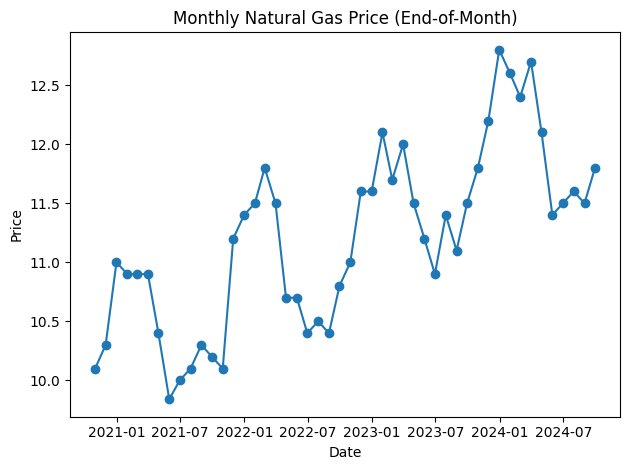

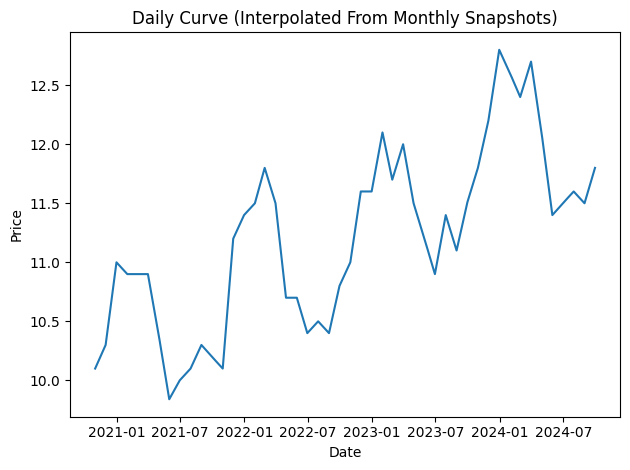

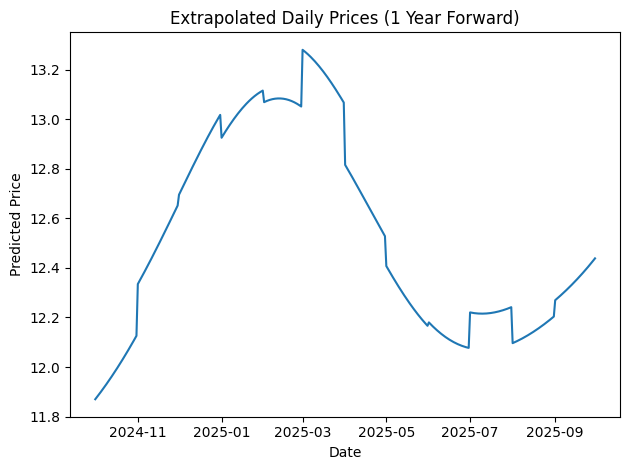

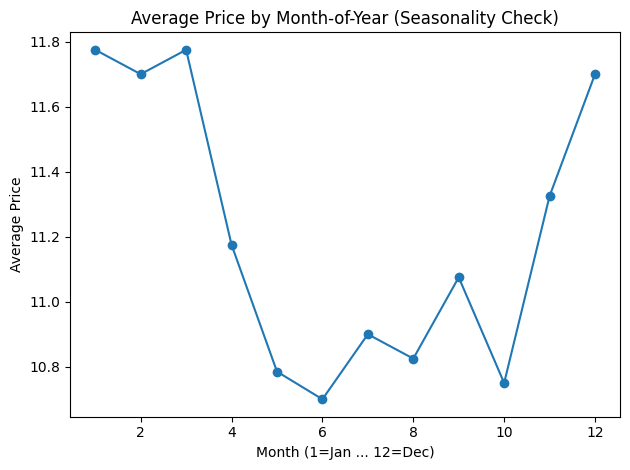

2021-02-15 -> 10.9
2024-09-30 -> 11.8
2025-03-15 -> 13.2006


In [8]:
# -----------------------------
# Run
# -----------------------------

df = load_natgas("Nat_Gas.csv")
model = fit_model(df)

plot_diagnostics(model)

for q in ["2021-02-15", "2024-09-30", "2025-03-15"]:
    print(q, "->", round(estimate_price(model, q), 4))
